In [18]:
# -*- coding: utf-8 -*- #

# Write libraries here #########################################
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from astroquery.gama import GAMA
from jupyterthemes import jtplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, cluster, preprocessing, mixture
from time import time
from tqdm import tnrange, tqdm_notebook
%matplotlib inline
################################################################


# Showing 500 columns and rows #################################
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
################################################################


# NOT CHANGE (The PATH for directory) ##########################
CURRENT_DIR_NAME = os.path.dirname(os.path.abspath(__name__))
PATH_DATA = os.path.join(CURRENT_DIR_NAME, '../data/')
PATH_HIST = os.path.join(CURRENT_DIR_NAME, '../histogram/')
PATH_PLOT = os.path.join(CURRENT_DIR_NAME, '../plots/')
PATH_IMG = os.path.join(CURRENT_DIR_NAME, '../images/')
PATH_HTML = os.path.join(CURRENT_DIR_NAME, '../html/')
PATH_TEX = os.path.join(CURRENT_DIR_NAME, '../for_tex/')
################################################################

#When you make plots, jtplot is better.
jtplot.style(theme='grade3', context='notebook', fscale=3, spines=True, gridlines='--', ticks=False, grid=False)

In [2]:
# Read the data

DATA_GAMA_KCORRECTED = GAMA.query_sql('SELECT * FROM kcorr_auto_z00 LIMIT 1000000')
#DATA_GAMA_MAGPHYS = GAMA.query_sql('SELECT * FROM MagPhys LIMIT 1000000')
#DATA_GAMA_FLUX = GAMA.query_sql('SELECT * FROM LambdarCat LIMIT 1000000')
#DATA_GAMA_REDSHIFT = GAMA.query_sql('SELECT * FROM AATRunzResults LIMIT 1000000')
#DATA_GAMA_FLUX = DATA_GAMA_FLUX.join(DATA_GAMA_REDSHIFT.drop(['RA', 'DEC'], axis=1))

In [3]:
# Arrange the Astropy table for the analysis (Convert into pd.DataFrame, set index and select samples which have reliable redshift)
DATA_GAMA_KCORRECTED = DATA_GAMA_KCORRECTED.to_pandas().set_index('CATAID').loc[DATA_GAMA_KCORRECTED['NQ'] >= 3]

# Show the details of our samples for manifold learning
display(DATA_GAMA_KCORRECTED.describe())

,Z_TONRY,NQ,KCORR_FUV,KCORR_NUV,KCORR_U,KCORR_G,KCORR_R,KCORR_I,KCORR_Z,KCORR_Y,KCORR_J,KCORR_H,KCORR_K,PCOEFF_R_1,PCOEFF_R_2,PCOEFF_R_3,PCOEFF_R_4,PCOEFF_R_5,COEFFS_1,COEFFS_2,COEFFS_3,COEFFS_4,COEFFS_5,CHI2,MASS,INTSFH,METS,B300,B1000
count,1.201150e+05,120115.000000,120115.000000,120115.000000,120115.000000,120115.000000,120115.000000,120115.000000,120115.000000,120115.000000,120115.000000,120115.000000,120115.000000,120115.000000,120115.000000,120115.000000,120115.000000,120115.000000,1.201150e+05,1.201150e+05,1.201150e+05,120115.000000,1.201150e+05,120115.000000,1.201150e+05,1.201150e+05,120115.000000,1.201150e+05,120115.000000
mean,2.102530e-01,4.117371,0.298762,0.180000,0.535269,0.540626,0.234931,0.092652,0.087742,0.115436,-0.012538,0.004374,-0.337844,-0.001630,1.681191,-5.004583,9.169657,-1.297186,3.718004e-06,8.858487e-10,6.352961e-07,0.000010,1.432389e-07,2.969902,3.497419e+10,6.317413e+10,0.029361,1.583267e-02,0.242814
std,1.176248e-01,0.379461,0.577276,0.301496,0.458254,0.395203,0.178455,0.156064,0.116931,0.128785,0.100708,0.074495,0.136714,0.003146,0.663278,6.554375,18.033434,17.351138,2.004618e-05,5.869321e-09,2.777456e-06,0.000049,8.118075e-07,28.303311,1.606658e+11,2.744741e+11,0.007705,4.179419e-02,0.189958
min,2.516310e-07,3.000000,-0.352638,-0.594598,-1.115860,-1.164900,-1.355630,-1.580410,-1.634620,-1.805990,-2.039130,-2.121330,-2.224310,-0.013576,-0.871678,-53.573300,-20.760800,-155.147000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,-0.000488,2.002930e+00,2.414790e+00,0.005685,2.532820e-14,0.000005
25%,1.298320e-01,4.000000,-0.111674,-0.037471,0.204564,0.226666,0.116046,-0.004126,0.020822,0.037358,-0.062662,-0.018755,-0.426080,-0.003864,1.228720,-8.794285,-4.405390,-10.409900,4.184955e-07,8.559345e-15,9.888450e-08,0.000001,2.337390e-09,0.122681,6.934730e+09,1.228825e+10,0.023264,2.163225e-04,0.083614
50%,1.942960e-01,4.000000,0.073773,0.123693,0.413285,0.466292,0.196622,0.079334,0.073892,0.111831,-0.021333,0.014760,-0.344369,-0.002394,1.591400,-3.426670,4.556350,2.973140,1.595040e-06,1.189030e-10,2.820830e-07,0.000005,3.784730e-08,0.403809,1.987040e+10,3.581970e+10,0.027652,2.916510e-03,0.191208
75%,2.826150e-01,4.000000,0.553732,0.344675,0.740101,0.792217,0.315451,0.174038,0.141830,0.181128,0.016216,0.042775,-0.246468,0.000396,2.097920,0.146076,18.712550,11.888000,3.425700e-06,7.792920e-10,5.967750e-07,0.000010,1.402205e-07,1.094790,4.297785e+10,7.816390e+10,0.033994,1.420335e-02,0.381603
max,3.870300e+00,5.000000,12.196200,5.772430,6.015170,3.283440,3.019000,3.542540,3.619720,3.604290,2.519850,1.636380,0.566933,0.019510,4.190600,5.787120,163.160000,23.822700,2.767090e-03,9.494590e-07,3.593880e-04,0.010879,9.381980e-05,2567.390000,3.304300e+13,5.489780e+13,0.050000,1.000000e+00,1.000000


## Show the distribution of redshift of our samples

# of samples = 120115


Text(0.5, 1.0, 'The redshift distribution of samples')

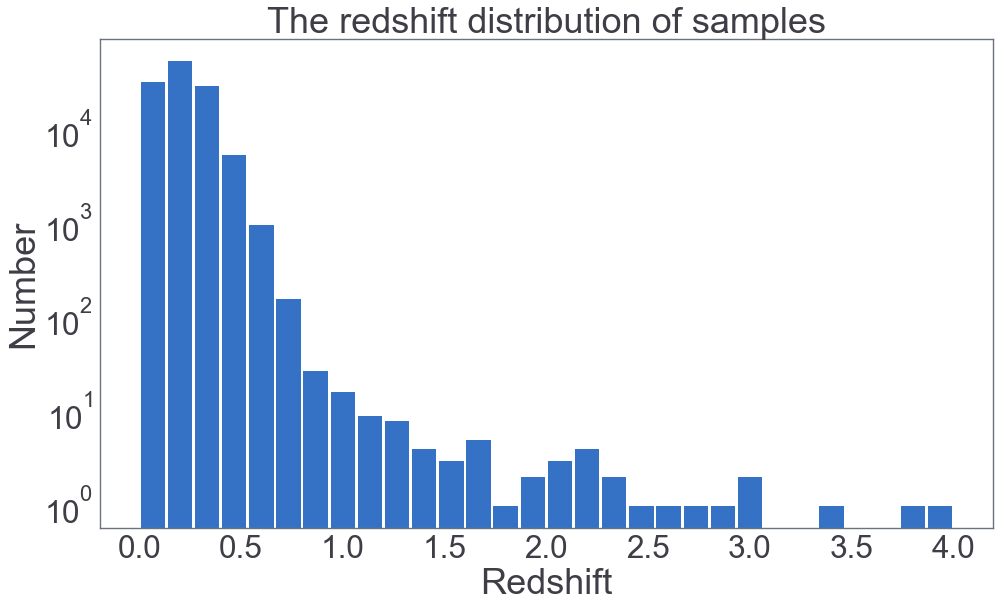

In [4]:
plt.figure(figsize=(16, 9))
plt.hist(DATA_GAMA_KCORRECTED['Z_TONRY'], range=[0, 4], bins=30,  rwidth=0.9)
print('# of samples = %s'%(len(DATA_GAMA_KCORRECTED['Z_TONRY'])))
plt.xlabel('Redshift')
plt.ylabel('Number')
plt.yscale('log')
plt.title('The redshift distribution of samples')

## Color-color plot (NUV-r and r-K)

Text(0, 0.5, 'NUV-r')

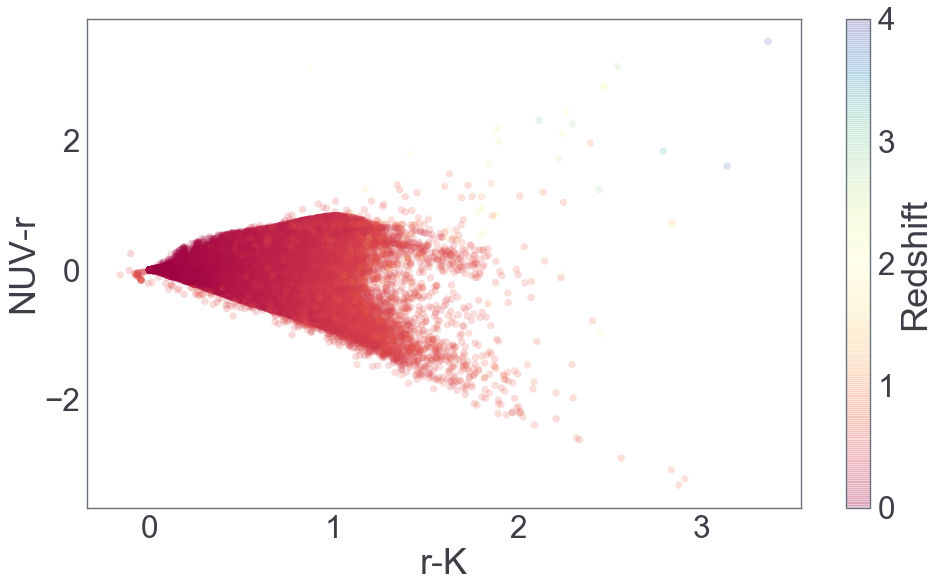

In [5]:
#  Color-color plot with colorbars based on redshift
plt.figure(figsize=(16, 9))
x = DATA_GAMA_KCORRECTED['KCORR_R'] - DATA_GAMA_KCORRECTED['KCORR_K']
y = DATA_GAMA_KCORRECTED['KCORR_NUV'] - DATA_GAMA_KCORRECTED['KCORR_R']
plt.scatter(x, y, c=DATA_GAMA_KCORRECTED['Z_TONRY'], alpha=0.2, cmap=plt.cm.Spectral)
cbar = plt.colorbar()  
cbar.set_label('Redshift')
plt.clim(vmin=0, vmax=4)
plt.xlabel('r-K')
plt.ylabel('NUV-r')

# Variational Bayesian Gaussian Mixture (VBGMM) for the classification

In [6]:
# Select columns for classification and manifold learning
data_for_manifoldlearning = DATA_GAMA_KCORRECTED[['Z_TONRY', 'KCORR_FUV', 'KCORR_NUV',
                                                  'KCORR_U', 'KCORR_G', 'KCORR_R', 'KCORR_I', 'KCORR_Z',
                                                  'KCORR_Y', 'KCORR_J', 'KCORR_H', 'KCORR_K']]

/usr/local/lib/python3.5/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


<BarContainer object of 15 artists>

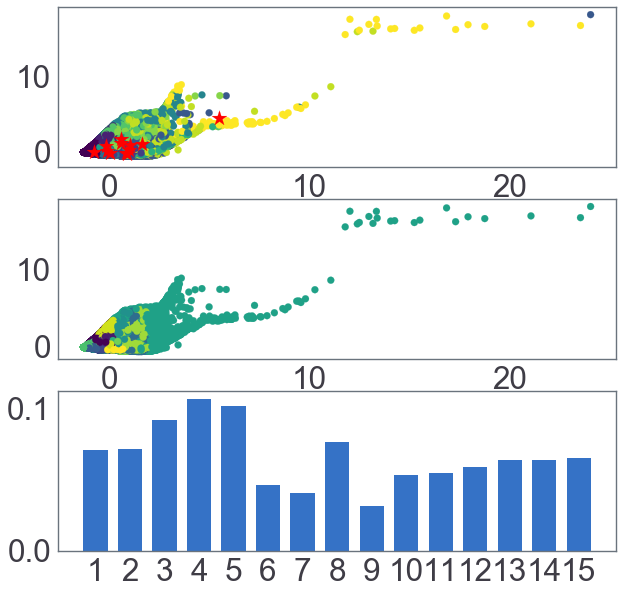

In [7]:
#X = data_for_manifoldlearning.drop('Z_SPEC', axis=1)
X = data_for_manifoldlearning

# RobustScaler uses [0.25, 0.75] samples
#sc=preprocessing.StandardScaler()
sc=preprocessing.RobustScaler()
sc.fit(X)
X_norm=sc.transform(X)

plt.figure(figsize=(10,10))
x=X_norm[:,0]
y=X_norm[:,1]

#Execute the K-means
km=cluster.KMeans(n_clusters=12)
z_km=km.fit(X_norm)

# Plot the K-means result
plt.subplot(311)
plt.scatter(x,y, c=z_km.labels_)
plt.scatter(z_km.cluster_centers_[:,0],z_km.cluster_centers_[:,1],s=250, marker='*',c='red')

# Execute the VBGMM
vbgm = mixture.BayesianGaussianMixture(n_components=15)
vbgm=vbgm.fit(X_norm)
labels=vbgm.predict(X_norm)

# Plot the VBGMM result
plt.subplot(312)
plt.scatter(x,y, c=labels)

# Plot the probability distribution calculated by VBGMM
#print(vbgm.weights_)
plt.subplot(313)
x_tick =np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.bar(x_tick, vbgm.weights_, width=0.7, tick_label=x_tick)

In [8]:
# Add the label from VBGMM to the original pd.DataFrame
data_for_manifoldlearning = data_for_manifoldlearning.join(pd.DataFrame(labels, index=data_for_manifoldlearning.index, columns=['label']))

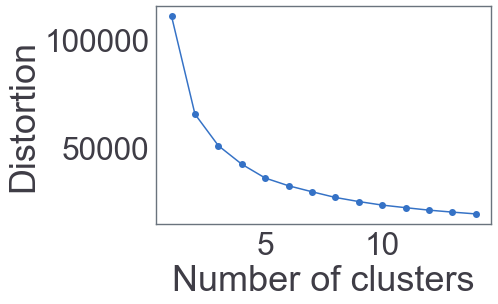

In [9]:
# How many clusters are the best for K-means?
distortions = []

for i in tnrange(1,15):
    km = cluster.KMeans(n_clusters=i,
                        init='k-means++',
                        n_init=10,
                        max_iter=300)
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1,15),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Text(0, 0.5, 'NUV-r')

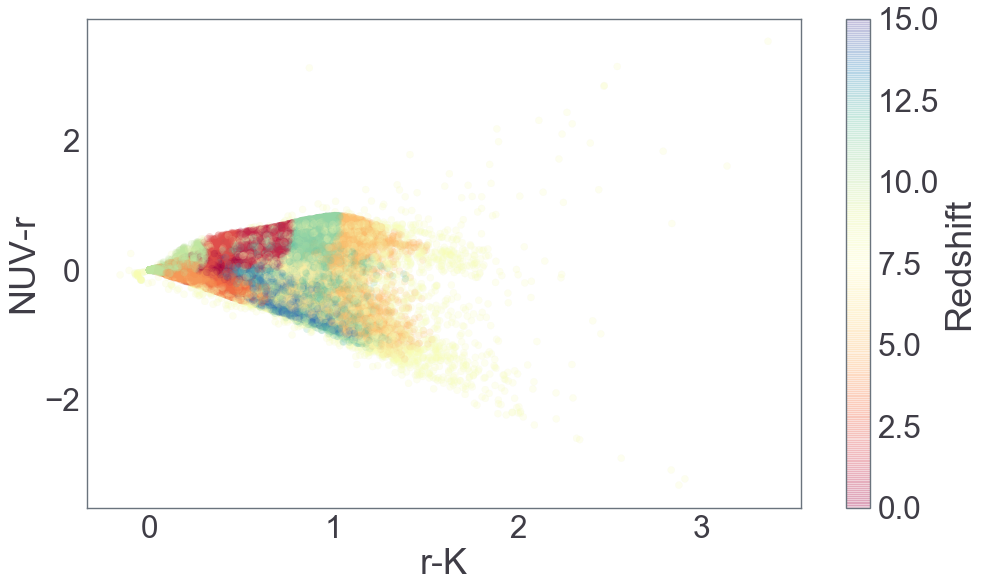

In [10]:
plt.figure(figsize=(16, 9))
#data_for_manifoldlearning = data_for_manifoldlearning.loc[data_for_manifoldlearning['Z_TONRY'] < 0.1]
x = data_for_manifoldlearning['KCORR_R'] - data_for_manifoldlearning['KCORR_K']
y = data_for_manifoldlearning['KCORR_NUV'] - data_for_manifoldlearning['KCORR_R']
plt.scatter(x, y, c=data_for_manifoldlearning['label'], alpha=0.2, cmap=plt.cm.Spectral)
cbar = plt.colorbar()  
cbar.set_label('Label')
plt.clim(vmin=0, vmax=15)
plt.xlabel('r-K')
plt.ylabel('NUV-r')

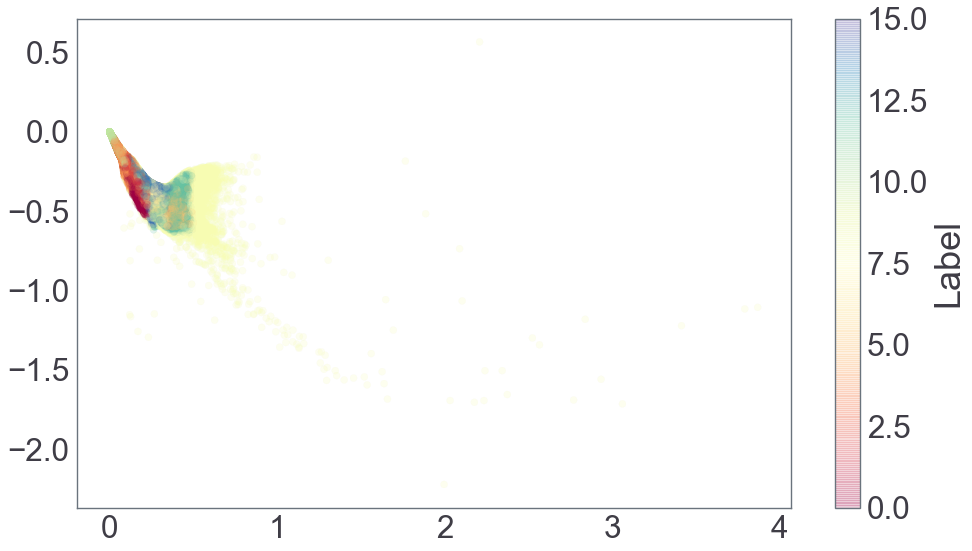

In [17]:
plt.figure(figsize=(16, 9))
#data_for_manifoldlearning = data_for_manifoldlearning.loc[data_for_manifoldlearning['Z_TONRY'] < 0.1]
y = data_for_manifoldlearning['KCORR_K']
x = data_for_manifoldlearning['Z_TONRY']
plt.scatter(x, y, c=data_for_manifoldlearning['label'], alpha=0.2, cmap=plt.cm.Spectral)
cbar = plt.colorbar()  
cbar.set_label('Label')
plt.clim(vmin=0, vmax=15)

In [15]:
'''
n_components = 2
nparray_data_for_manifoldlearning = data_for_manifoldlearning.values
X = nparray_data_for_manifoldlearning
fig = plt.figure(figsize=(32, 27))

for i in tnrange(6):
    n_neighbors = i+10
    
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method='standard').fit_transform(X)
    t1 = time()
    ax = fig.add_subplot(321+i)
    ax.scatter(Y[:, 0], Y[:, 1], alpha=0.2, c=data_for_manifoldlearning['label'], cmap=plt.cm.Spectral)
    ax.set_title("Manifold Learning (LLE) with %i neighbors (%.2g sec)" % (n_neighbors, t1 - t0))
'''

'\nn_components = 2\nnparray_data_for_manifoldlearning = data_for_manifoldlearning.values\nX = nparray_data_for_manifoldlearning\nfig = plt.figure(figsize=(32, 27))\n\nfor i in tnrange(6):\n    n_neighbors = i+10\n    \n    t0 = time()\n    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,\n                                        eigen_solver=\'auto\',\n                                        method=\'standard\').fit_transform(X)\n    t1 = time()\n    ax = fig.add_subplot(321+i)\n    ax.scatter(Y[:, 0], Y[:, 1], alpha=0.2, c=data_for_manifoldlearning[\'label\'], cmap=plt.cm.Spectral)\n    ax.set_title("Manifold Learning (LLE) with %i neighbors (%.2g sec)" % (n_neighbors, t1 - t0))\n'